## 1. Dataset and libraries

In [ ]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## 2. Reading and Exploring the Data

We must set up the data and assign each label with every corresponding image

In [ ]:
LABELS = ["PNEUMONIA", "NORMAL"]
IMG_SIZE = 150

def get_training_data(data_dir: str):
    images = []
    labels = []
    for label in LABELS:
        path = os.path.join(data_dir, label)
        class_num = LABELS.index(label)
        for img in os.listdir(path):
            if not img.endswith(".jpeg"):
                continue
            try:
                img_arr = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Failed to load image: {img}")
                    continue
                resized_arr = cv.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                images.append(resized_arr)
                labels.append(class_num)
            except Exception as e:
                print(e)
    return np.array(images), np.array(labels)

In [3]:
dataset_path = r"K:\User\Dektop\College\Nti Huawei\Project\chest_xray\chest_xray"  # <-- update this with your actual path

print("dataset path:", dataset_path)

# Now load the data using your loading function
train_data, train_labels = get_training_data(os.path.join(dataset_path, "train"))
test_data, test_labels = get_training_data(os.path.join(dataset_path, "test"))
val_data, val_labels = get_training_data(os.path.join(dataset_path, "val"))

dataset path: K:\User\Dektop\College\Nti Huawei\Project\chest_xray\chest_xray


# Visualizing the Data

This plot shows the number of training images in each class (Pneumonia vs Normal), helping to identify any class imbalance in the dataset.


<Axes: xlabel='count'>

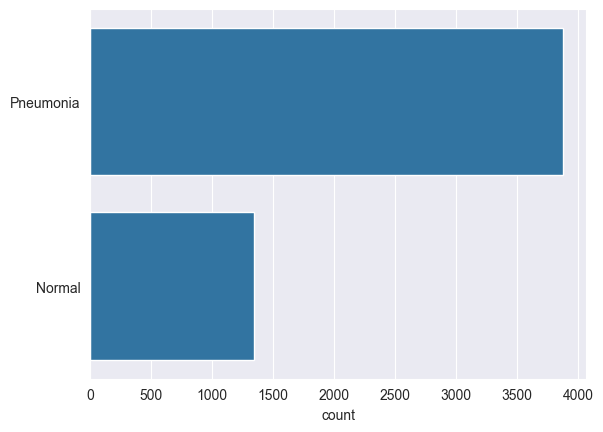

In [4]:
train_cl = []
for i in train_labels:
    train_cl.append("Pneumonia" if i == 0 else "Normal")
sns.set_style("darkgrid")
sns.countplot(train_cl)

Text(0.5, 1.0, 'NORMAL')

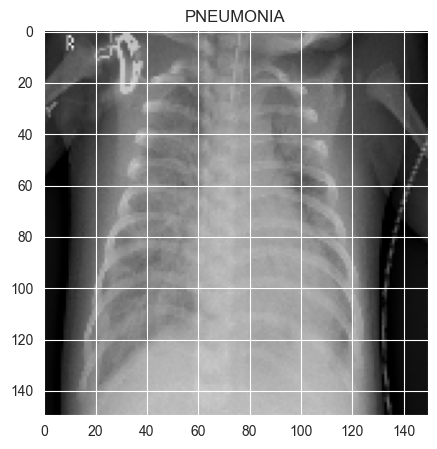

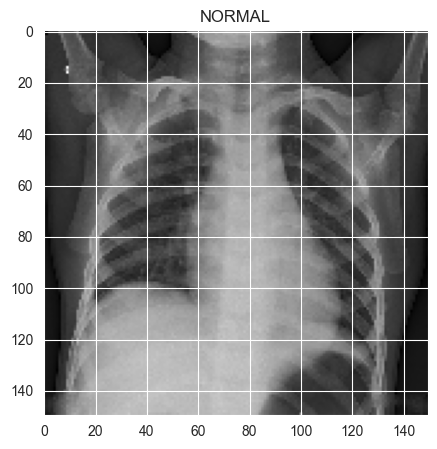

In [5]:
plt.figure(figsize=(5, 5))
plt.imshow(train_data[0], cmap="gray")
plt.title(LABELS[train_labels[0]])
plt.figure(figsize=(5, 5))
plt.imshow(train_data[-1], cmap="gray")
plt.title(LABELS[train_labels[-1]])

# Data Normalization and Reshaping

This step prepares the image data for training:
- **Normalization**: Scales pixel values to the range [0, 1] for better training performance.
- **Reshaping**: Adds a channel dimension (1 for grayscale) to match the CNN input shape `(IMG_SIZE, IMG_SIZE, 1)`.


In [6]:
# Normalize the data
x_train = np.array(train_data) / 255
x_val = np.array(val_data) / 255
x_test = np.array(test_data) / 255


# resize data for deep learning 
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(train_labels)

x_val = x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(val_labels)

x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(test_labels)

## 3. Data Augmentation

Creating modified versions of your training data (like flipping, rotating, zooming images) to increase dataset size and diversity. This helps the model generalize better to improve reliablity and reduces overfitting.

In [ ]:
img = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise _center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.2,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
)
img.fit(x_train)

# 4. Assigning a CNN Model for Binary Image Classification

This model uses multiple convolutional, pooling, and dropout layers to extract features from 150x150 grayscale images and classify them into one of two classes. It ends with a sigmoid output for binary prediction.


In [8]:
model = Sequential(
    [
        Conv2D(32, (3, 3), strides=1, padding="same", activation="relu", input_shape=(150, 150, 1),),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),

        Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"),
        Dropout(0.1),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        
        Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        
        Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"),
        Dropout(0.2),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        
        Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"),
        Dropout(0.2),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        
        Flatten(),
        Dense(units=128, activation="relu"),
        Dropout(0.2),
        Dense(units=1, activation="sigmoid"),
    ]
)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

c:\Users\khahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

## 6. Training Optimization

These callbacks help improve and control the training process:
- **EarlyStopping**: Stops training early if validation loss doesn't improve for 3 epochs and restores the best weights.
- **ReduceLROnPlateau**: Reduces the learning rate when validation accuracy stops improving to fine-tune learning.
- **ModelCheckpoint**: Saves the best model based on validation accuracy during training.


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',     # You can also use 'val_accuracy' if you prefer
    patience=3,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy",
    patience=2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

checkpoint = ModelCheckpoint(
    'best_model.h5',              # File to save the model
    monitor='val_accuracy',           # Save the model when validation loss improves
    save_best_only=True,          # Only keep the best version
    mode='max',                   # Lower val_loss = better model
    verbose=1
)

## 7. Model Training

The model is trained using augmented image data with a batch size of 32 for 15 epochs. Validation is performed on a separate set, and callbacks are used to:
- stop early if there's no improvement,
- reduce learning rate when needed,
- and save the best-performing model.


In [10]:
history = model.fit(
    img.flow(x_train, y_train, batch_size=32),
    epochs=15,
    validation_data=img.flow(x_val, y_val),
    callbacks=[learning_rate_reduction, early_stop, checkpoint] 
)

c:\Users\khahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7958 - loss: 1.0474
Epoch 1: val_accuracy improved from inf to 0.62069, saving model to best_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.7960 - loss: 1.0442 - val_accuracy: 0.6207 - val_loss: 12.9641 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8812 - loss: 0.3271
Epoch 2: val_accuracy did not improve from 0.62069
163/163 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8813 - loss: 0.3269 - val_accuracy: 0.6207 - val_loss: 5.1629 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9130 - loss: 0.2355
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 3: val_accuracy did not improve from 0.62069
163/163 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9131 - loss: 0.2354 - val_accuracy: 0.6207 - val_loss: 40.7838 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9435 - loss: 0.1523
Epoch 4: val_accuracy did not improve from 0.62069
163/163 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9435 - loss: 0.1523 - val_accur

## 8. Model Evaluation

The model is evaluated on the test set to check its final performance. It includes:
- Calculating and printing test loss and accuracy.

In [11]:
model_loss, model_accuracy = model.evaluate(x_test, y_test)
print("model loss:", model_loss * 100)
print("model accuracy:", model_accuracy * 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.9366 - loss: 0.1830
model loss: 25.6460040807724
model accuracy: 90.65420627593994


- Generating predictions and converting them to binary class labels.

In [12]:
predictions = model.predict(x_test)
y_predictions= np.array([1 if prob > 0.5 else 0 for prob in predictions.flatten()])
y_predictions[:15]

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

- Plotting a confusion matrix to visualize correct and incorrect classifications.

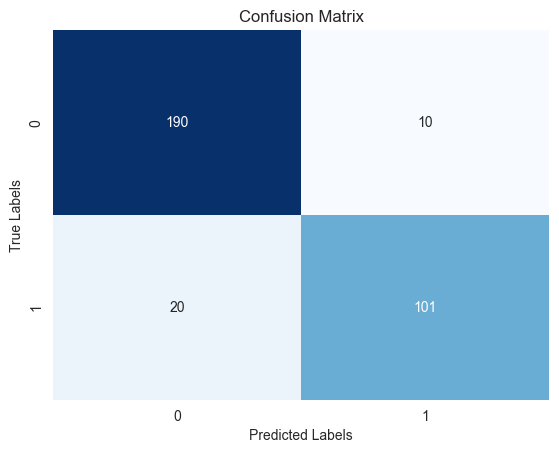

In [13]:
cm = confusion_matrix(y_test, y_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

- Printing a classification report showing precision, recall, F1-score, and support for each class.

In [ ]:
print(classification_report(y_test, y_predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.95      0.93       200
   Normal (Class 1)       0.91      0.83      0.87       121

           accuracy                           0.91       321
          macro avg       0.91      0.89      0.90       321
       weighted avg       0.91      0.91      0.91       321



# Training History Visualization

This section visualizes the model’s training progress:
- Plots training and validation **accuracy** over all epochs.
- Plots training and validation **loss** over all epochs.
This helps in diagnosing underfitting, overfitting, or stable learning.


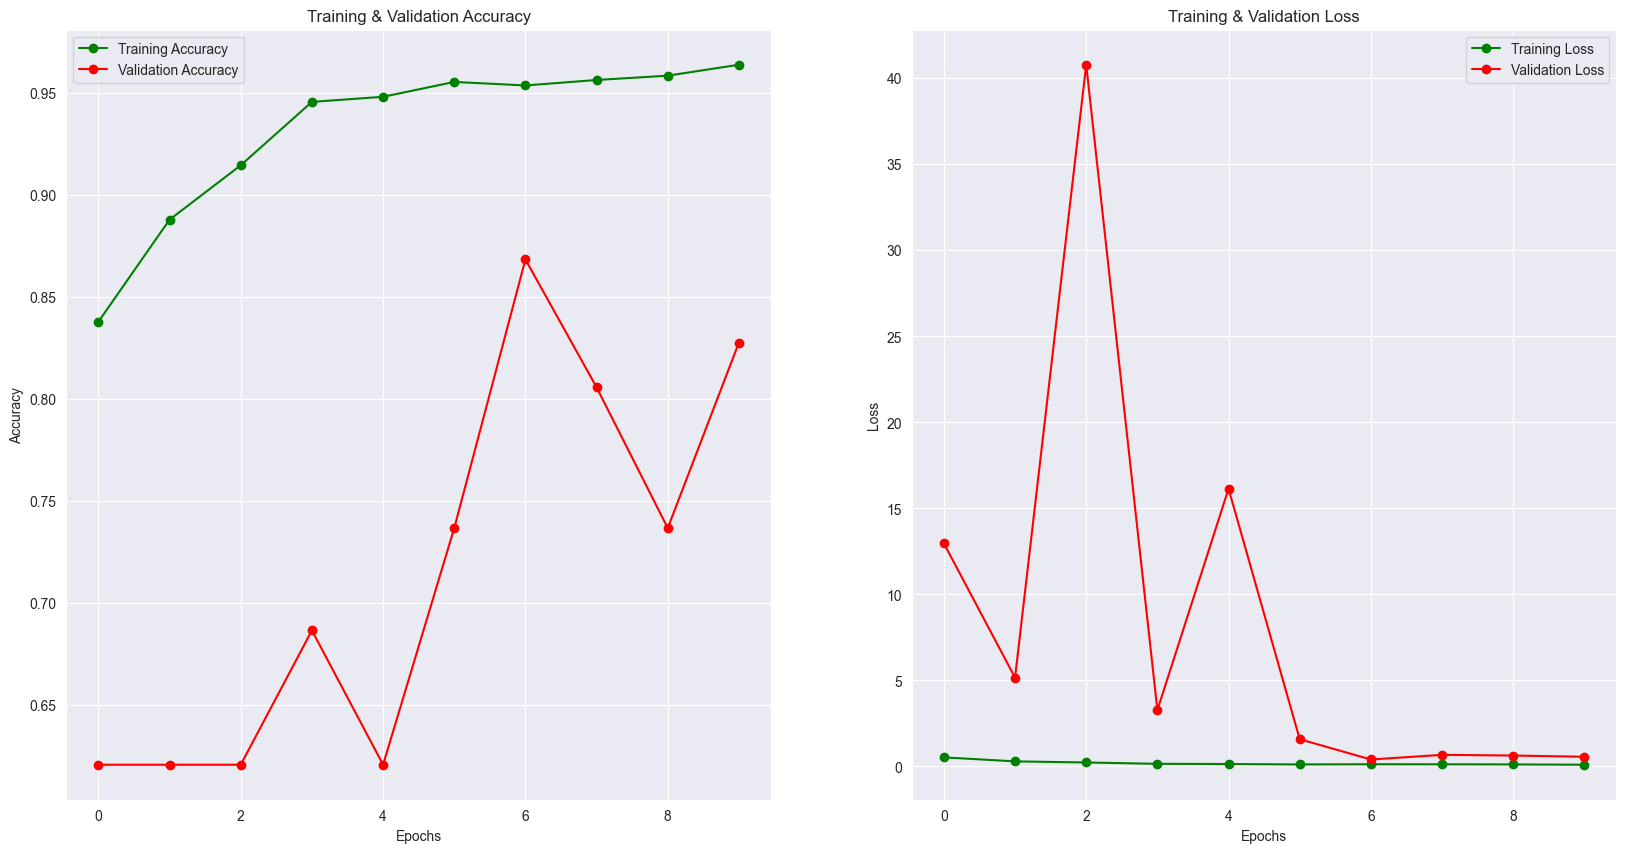

In [25]:
import matplotlib.pyplot as plt

# Get the number of actual epochs from the history object
num_epochs = len(history.history['accuracy'])
epochs = [i for i in range(num_epochs)]

# Extract training and validation metrics
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Create subplots for accuracy and loss
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

# Plot accuracy
ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Plot loss
ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')  # Fixed 'g-o' to 'go-'
ax[1].plot(epochs, val_loss, 'ro-', label='Validation Loss')  # Fixed 'r-o' to 'ro-'
ax[1].set_title('Training & Validation Loss')  # Corrected title
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

# Visualizing Correct and Incorrect Predictions

This section displays examples of:
- **Correct predictions**: Images where the model's prediction matches the actual label.
- **Incorrect predictions**: Images where the model's prediction differs from the actual label.

Each image shows the predicted and actual class to help visually assess model performance.


In [21]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

predictions_classes shape: (321,)
correct[:6]: [0 1 2 3 4 5]


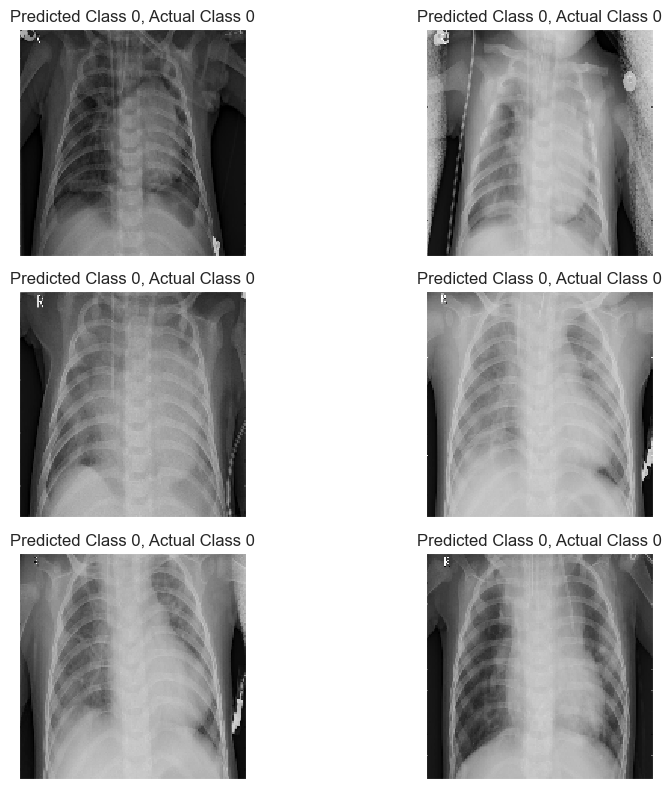

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Convert predictions to class labels (threshold 0.5)
predictions_classes = (predictions > 0.5).astype(int).flatten()  # Shape (321,)
print(f"predictions_classes shape: {predictions_classes.shape}")

# Find correct predictions
correct = np.where(predictions_classes == y_test)[0]
print(f"correct[:6]: {correct[:6]}")

# Create figure
plt.figure(figsize=(10, 8))

# Loop to plot the first 6 correct predictions
i = 0
for c in correct[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c][:, :, 0], cmap="gray", interpolation='none')  # Use [:, :, 0] for (150, 150, 1) shape
    plt.title(f"Predicted Class {predictions_classes[c]}, Actual Class {y_test[c]}")
    i += 1

plt.tight_layout()
plt.show()

predictions_classes shape: (321,)
incorrect[:6]: [ 21  34  52  72  73 120]


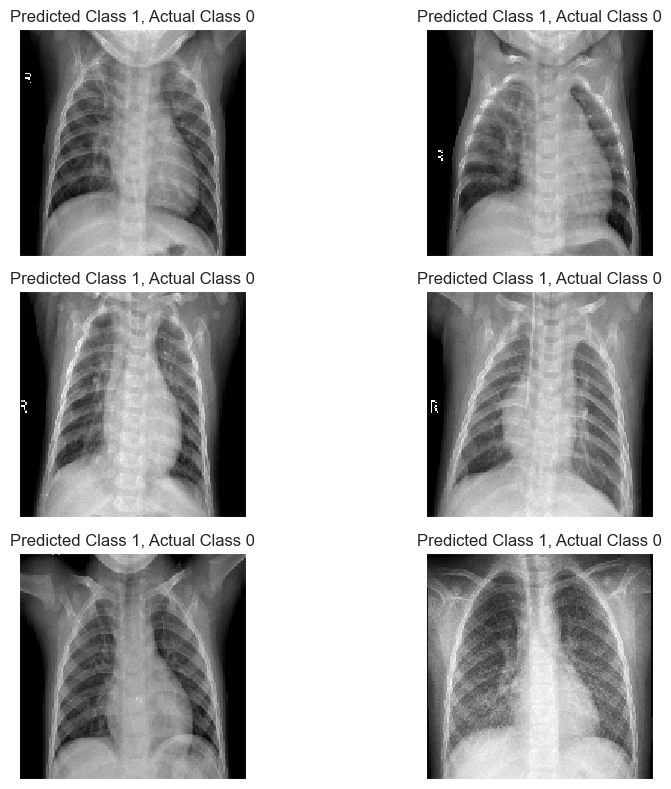

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Convert predictions to class labels (threshold 0.5)
predictions_classes = (predictions > 0.5).astype(int).flatten()  # Shape (321,)
print(f"predictions_classes shape: {predictions_classes.shape}")

# Find incorrect predictions
incorrect = np.where(predictions_classes != y_test)[0]
print(f"incorrect[:6]: {incorrect[:6]}")

# Create figure
plt.figure(figsize=(10, 8))

# Loop to plot the first 6 incorrect predictions
i = 0
for c in incorrect[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c][:, :, 0], cmap="gray", interpolation='none')  # Use [:, :, 0] for (150, 150, 1)
    plt.title(f"Predicted Class {predictions_classes[c]}, Actual Class {y_test[c]}")
    i += 1

plt.tight_layout()
plt.show()

# Manually Predicting a Random Image of Your Choice

This section loads a single chest X-ray image, preprocesses it (grayscale, resize, normalize), and passes it to the trained model for prediction.  
It then:
- Displays the image with the predicted class.
- Prints the prediction score and label (Normal or Pneumonia).


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Prediction score: 0.414889


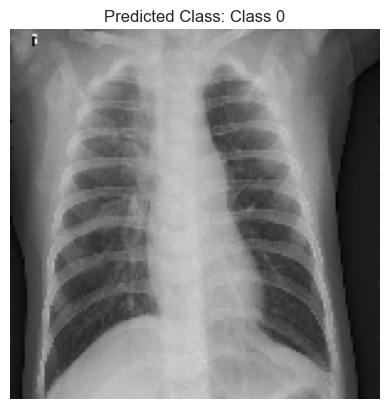

 Predicted Class  Pneumonia 


In [33]:

from tensorflow.keras.preprocessing import image
img_path = r"K:\User\Dektop\College\Nti Huawei\Project\chest_xray\chest_xray\test\PNEUMONIA\person17_virus_48.jpeg"  
img = image.load_img(img_path, target_size=(150, 150), color_mode='grayscale')

img_array = image.img_to_array(img)  


img_array = img_array / 255.0


img_array = np.expand_dims(img_array, axis=0) # ش(1, 150, 150, 1)

prediction = model.predict(img_array)


print("Prediction score:", prediction[0][0])




plt.imshow(img, cmap='gray')
plt.title("Predicted Class: {}".format("Class 1" if prediction[0][0] > 0.5 else "Class 0"))
plt.axis('off')
plt.show()

if prediction[0][0] > 0.5:
    print(" Predicted Class:  Normal")
else:
    print(" Predicted Class  Pneumonia ")